# NLP sentiment prediction

## Setup environment and libraries

In [32]:
SEED = 0

In [33]:
!pip install -U spacy
!python -m spacy download es_core_news_md

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.6)
2021-06-27 20:09:39.598447: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [34]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import spacy
import nltk
import time
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import classification_report

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load dataset

In [37]:
emotions_df = pd.read_csv('app_records_cleaned.csv')
emotions_df

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,10,2019-05-04,levantar comer frustrar,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.1500,398.0,720.0,32400.0,22.0,0.0,8090.0,0.0,20588.0,55.0,5157.0,20603.0,0.0,0.0,2398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003554,70200.0,0.0,0.0,0.0,6.0
1,10,2019-05-05,hoy despertar pero no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.9200,2491.0,3986.0,28800.0,28.0,0.0,2620.0,0.0,20836.0,889.0,2118.0,11749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001379,75600.0,0.0,0.0,0.0,6.0
2,10,2019-05-06,no comer noche,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.2000,1111.0,1773.0,28800.0,30.0,0.0,8200.0,0.0,24300.0,280.0,8139.0,9901.0,0.0,0.0,4113.0,0.0,0.0,0.0,3109.0,0.0,0.0,0.012274,64800.0,0.0,0.0,0.0,15.0
3,10,2019-05-07,no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,28.5104,17.0,3866.0,28800.0,38.0,0.0,8520.0,0.0,42604.0,1577.0,12109.0,16635.0,0.0,0.0,4997.0,0.0,0.0,0.0,742.0,2.0,0.0,0.000012,30600.0,0.0,0.0,0.0,2.0
4,10,2019-05-20,viaje,0,0,0,1,0,0,0,0,0,0,0,0,0,4909.5400,8.0,1824.0,11958.0,0.0,0.0,4044.0,0.0,20178.0,519.0,7841.0,16960.0,0.0,0.0,4207.0,0.0,0.0,0.0,30.0,0.0,0.0,0.000013,34200.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5153,2690,2020-03-11,día,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0000,0.0,0.0,25800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4.0,0.0,0.0,0.0
5154,2690,2020-03-23,niña discutir,1,0,0,0,0,0,1,0,0,0,0,0,0,0.0000,0.0,0.0,23400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.0,0.0,0.0,0.0
5155,2690,2020-03-23,niña guerra,1,0,0,0,0,0,1,0,0,0,0,0,0,0.0000,0.0,0.0,23400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.0,0.0,0.0,0.0
5156,2690,2020-03-27,complicación firmo trabajo,1,0,0,0,0,0,0,0,0,1,0,0,0,641.4610,0.0,5413.0,42000.0,0.0,0.0,0.0,0.0,0.0,5295.0,0.0,28367.0,0.0,554.0,608.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,1.0,0.0,554.0,0.0


In [38]:
print('Null values:', np.sum(emotions_df.isnull().values))

Null values: 0


## Data arrangement

SOS and EOS tags creation

In [39]:
nlp = spacy.load('es_core_news_md')

Check that do not exist right now. 

In [40]:
print(f'SOS in vocab: {nlp.vocab.has_vector("<sos>")}')
print(f'EOS in vocab: {nlp.vocab.has_vector("<eos>")}')

SOS in vocab: False
EOS in vocab: False


We add for the tokenizer the tags. 

In [41]:
nlp.tokenizer.add_special_case('<sos>', [{spacy.symbols.ORTH: "<sos>"}])
nlp.tokenizer.add_special_case('<eos>', [{spacy.symbols.ORTH: "<eos>"}])

In [42]:
doc = nlp('<sos> Hola que tal estas <eos>')
for token in doc:
    print(token.text, token.pos_, token.dep_)

<sos> NUM ROOT
Hola PROPN flat
que SCONJ mark
tal PRON det
estas PRON fixed
<eos> NUM conj


Creates the new vectors and links them to the <sos> and <eos> tags. 

In [43]:
np.random.seed(SEED)
sos_vector = np.random.rand(300).astype(np.float32)
eos_vector = np.random.rand(300).astype(np.float32)
nlp.vocab.set_vector('<sos>', sos_vector)
nlp.vocab.set_vector('<eos>', eos_vector)
print(f'SOS in vocab: {nlp.vocab.has_vector("<sos>")}')
print(f'EOS in vocab: {nlp.vocab.has_vector("<eos>")}')

SOS in vocab: True
EOS in vocab: True


In [44]:
print(sos_vector[:5])
print(nlp.vocab.get_vector('<sos>')[:5])
print(eos_vector[:5])
print(nlp.vocab.get_vector('<eos>')[:5])

[0.5488135  0.71518934 0.60276335 0.5448832  0.4236548 ]
[0.5488135  0.71518934 0.60276335 0.5448832  0.4236548 ]
[0.9065555  0.7740473  0.33314514 0.08110139 0.40724117]
[0.9065555  0.7740473  0.33314514 0.08110139 0.40724117]


It returns a DataFrame with all the field, including the emotion text field with the <SOS> and the <EOS> tags and regularized.

In [45]:
def add_eos_sos_tags(text):
    words = text.split(' ')
    words.insert(0, '<sos>')
    words.append('<eos>')
    return ' '.join(words)

In [46]:
def regularize_text(max_words, text):
    words = text.split(' ')
    len_words = len(words)
    if (len_words < max_words):
        eos = ['<eos>'] * (max_words - len_words)
        words = words + eos
    return ' '.join(words)

In [47]:
def obtain_n_rows_from_sentence(word2row, text):
    words = text.split(' ')
    rows = [word2row[w] for w in words]
    return rows

In [48]:
def obtain_words_from_rows(rows_array):
    words = [[row2word[rows_array[i, j]] \
              for j in range(rows_array.shape[1])] \
                          for i in range(rows_array.shape[0])]
    return np.array(words)

In [49]:
def arrange_data(df):
    # Compute maximum number of words
    df_aux = df.copy()
    # First, we add the tags
    emotion_texts = df_aux['emotion_text']
    emotion_texts_tags = emotion_texts.apply(lambda x: add_eos_sos_tags(x))
    # Then, compute the words used
    df_aux['words_used'] = emotion_texts_tags.apply(lambda x: len(x.split()))
    # Then, compute the maximum words 
    max_words = len(max(emotion_texts_tags, key=lambda x: len(x.split())).split())
    print('The maximum number of words in a text:', max_words)
    emotion_texts_reg = emotion_texts_tags\
                                .apply(lambda x: regularize_text(max_words, x))
    df_aux['emotion_text_reg'] = emotion_texts_reg    

    vocab = set(df_aux.emotion_text_reg.str.cat(sep=' ').split(' '))
    print('Number of words in the vocabulary:', len(vocab))
    word2row = {w: i for i, w in enumerate(vocab)}
    row2word = {i: w for i, w in enumerate(vocab)}
    word_embed = np.zeros((len(vocab), 300), dtype=np.float32)
    for i, w in enumerate(vocab):
        word_embed[i] = nlp.vocab.get_vector(w)
    
    text_row_regular = df_aux.emotion_text_reg.\
        apply(lambda x: obtain_n_rows_from_sentence(word2row, x))

    df_aux['emotion_text_row'] = text_row_regular

    return df_aux, word2row, row2word, word_embed

In [50]:
emotions_df_reg, word2row, row2word, word_embed = arrange_data(emotions_df)

The maximum number of words in a text: 17
Number of words in the vocabulary: 3409


In [51]:
emotions_df_reg.head(3)

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count,words_used,emotion_text_reg,emotion_text_row
0,10,2019-05-04,levantar comer frustrar,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.15,398.0,720.0,32400.0,22.0,0.0,8090.0,0.0,20588.0,55.0,5157.0,20603.0,0.0,0.0,2398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003554,70200.0,0.0,0.0,0.0,6.0,5,<sos> levantar comer frustrar <eos> <eos> <eos...,"[474, 2626, 645, 1740, 2426, 2426, 2426, 2426,..."
1,10,2019-05-05,hoy despertar pero no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.92,2491.0,3986.0,28800.0,28.0,0.0,2620.0,0.0,20836.0,889.0,2118.0,11749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001379,75600.0,0.0,0.0,0.0,6.0,7,<sos> hoy despertar pero no comer <eos> <eos> ...,"[474, 2504, 611, 533, 1308, 645, 2426, 2426, 2..."
2,10,2019-05-06,no comer noche,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.20,1111.0,1773.0,28800.0,30.0,0.0,8200.0,0.0,24300.0,280.0,8139.0,9901.0,0.0,0.0,4113.0,0.0,0.0,0.0,3109.0,0.0,0.0,0.012274,64800.0,0.0,0.0,0.0,15.0,5,<sos> no comer noche <eos> <eos> <eos> <eos> <...,"[474, 1308, 645, 1501, 2426, 2426, 2426, 2426,..."


### 4 variables aggregation

We are going to predict, given a text, whether the person is happy, normal, upset or angry. 

In [21]:
happy = ['encantado', 'feliz', 'motivado', 'relajado']
normal = 'neutro'
upset = ['disgustado', 'tristeza', 'agobiado', 'cansado', 'dolor', 'asustado']
angry = 'ira'

happy_df = np.sum(emotions_df_reg[happy], axis=1)
normal_df = emotions_df_reg[normal]
sad_df = np.sum(emotions_df_reg[upset], axis=1)
angry_df = emotions_df_reg[angry]

emotions_df_reg.insert(4, column='happy', value=happy_df)
emotions_df_reg.insert(5, column='normal', value=normal_df)
emotions_df_reg.insert(6, column='upset', value=sad_df)
emotions_df_reg.insert(7, column='angry', value=angry_df)

In [22]:
emotions_list = happy + ['neutro'] + upset + ['ira']
emotions_occur = [np.sum(emotions_df_reg[emotion]) for emotion in emotions_list]

In [25]:
emotions_list = ['happy', 'normal', 'upset', 'angry']
emotions_occur = [np.sum(emotions_df_reg[emotion]) for emotion in emotions_list]

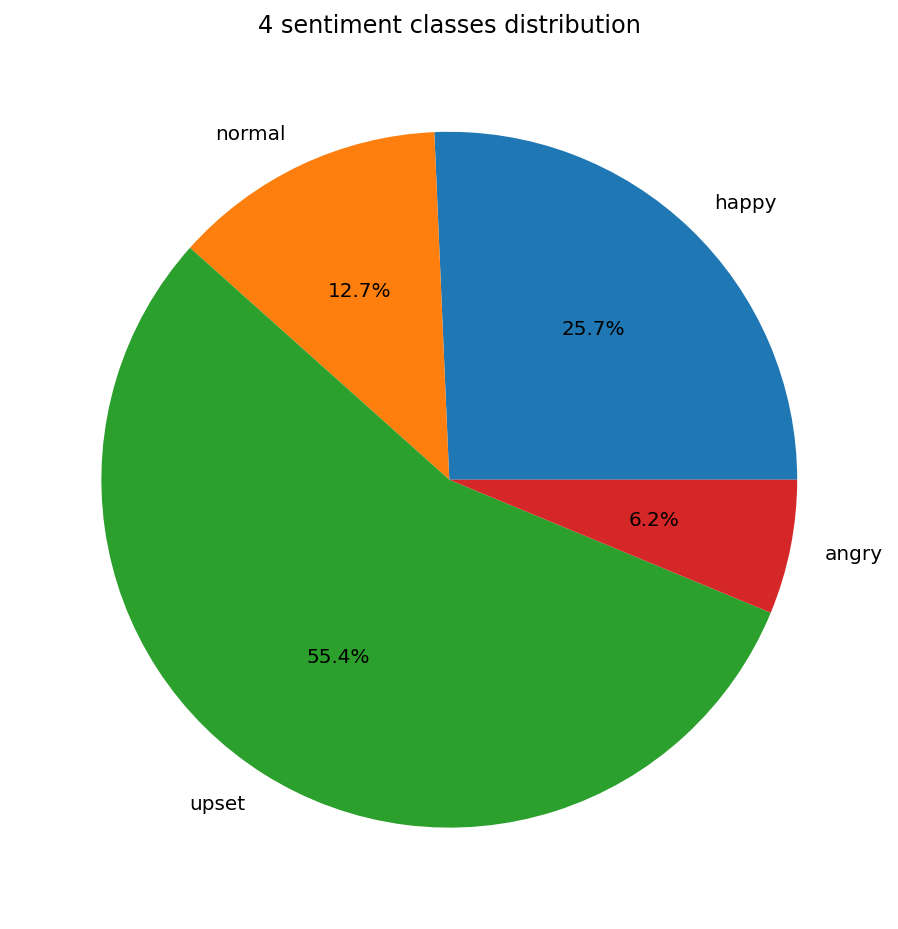

In [27]:
pie_chart_all_emotions = pd.DataFrame(zip(emotions_list, emotions_occur),
                                      columns=['Emotions', 'Occurrences'])
pie_chart_all_emotions = pie_chart_all_emotions.set_index('Emotions')
pie_chart_all_emotions.Occurrences.plot.pie(title='4 sentiment classes distribution',
                                ylabel='', autopct='%1.1f%%', 
                                figsize=(8, 8))
plt.savefig('emotion_generator_4_classes.png', dpi=300)

In [ ]:
emotions_df_reg.head(2)

,id,date,emotion_text,sad,happy,normal,upset,angry,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count,words_used,emotion_text_reg,emotion_text_row
0,10,2019-05-04,levantar comer frustrar,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.15,398.0,720.0,32400.0,22.0,0.0,8090.0,0.0,20588.0,55.0,5157.0,20603.0,0.0,0.0,2398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003554,70200.0,0.0,0.0,0.0,6.0,5,<sos> levantar comer frustrar <eos> <eos> <eos...,"[2235, 1819, 2602, 473, 2468, 2468, 2468, 2468..."
1,10,2019-05-05,hoy despertar pero no comer,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.92,2491.0,3986.0,28800.0,28.0,0.0,2620.0,0.0,20836.0,889.0,2118.0,11749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001379,75600.0,0.0,0.0,0.0,6.0,7,<sos> hoy despertar pero no comer <eos> <eos> ...,"[2235, 1438, 2121, 1315, 1564, 2602, 2468, 246..."


In [ ]:
emotion_attr = ['happy', 'normal', 'upset', 'angry']
Y = torch.FloatTensor(emotions_df_reg[emotion_attr].values)
y = Y.max(dim=1)[1]

### Sad variable

In [84]:
emotion_attr = ['sad']
y = torch.FloatTensor(emotions_df_reg[emotion_attr].values)

### Data preparation

X and Y are matrix with the word row number already regularized. 

In [85]:
text_rows = emotions_df_reg['emotion_text_row']
text_rows = np.array(text_rows.values.tolist())
X = torch.LongTensor(text_rows)

# Get the app records measures
app_cols = emotions_df_reg.columns[16:-3]
app_records = emotions_df_reg[app_cols]
X_app = torch.FloatTensor(app_records.values)

words_used = torch.LongTensor(emotions_df_reg['words_used'].values) 
word_embed = torch.FloatTensor(word_embed)
record_ids = np.arange(emotions_df_reg.shape[0])

In [86]:
print(X.shape)
print(y)
print(y.shape)
print(words_used)

torch.Size([5158, 17])
tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])
torch.Size([5158, 1])
tensor([5, 7, 5,  ..., 4, 5, 4])


## Dataset implementation and initialization

In [87]:
class EmotionSumDataset(Dataset):

    def __init__(self, x_words_row, y_emotion, x_app_vector, n_words_used,
                 record_ids):        
        self.x_words_row = x_words_row
        self.y_emotion = y_emotion
        self.x_app_vector = x_app_vector
        self.n_words_used = n_words_used
        self.record_ids = record_ids

    def get_sequence(self, idxs):
        return (
            self.x_words_row[idxs],
            self.y_emotion[idxs],
            self.x_app_vector[idxs],
            self.n_words_used[idxs],
            self.record_ids[idxs]
        )

    def __size__(self):
        return self.x_words_row.shape[0]

    def __len__(self):
        return self.x_words_row.shape[0]
    
    def __getitem__(self, idx):
        return (
            self.x_words_row[idx],
            self.y_emotion[idx],
            self.x_app_vector[idx],
            self.n_words_used[idx],
            self.record_ids[idx]
        )


In [88]:
def train_test_split(emotion_sum_dataset, test_size=0.2, shuffle=True):
    total_rows = len(emotion_sum_dataset)
    test_rows = int(total_rows*test_size)
    train_rows = total_rows - test_rows
    if shuffle:
        permutation = np.random.default_rng(SEED).permutation(total_rows)
    else:
        permutation = np.arange(total_rows)
    train_idxs = permutation[:train_rows]
    test_idxs = permutation[train_rows:]
    emotion_sum_train = emotion_sum_dataset.get_sequence(train_idxs)
    emotion_sum_train_dataset = EmotionSumDataset(*emotion_sum_train)
    emotion_sum_test = emotion_sum_dataset.get_sequence(test_idxs)
    emotion_sum_test_dataset = EmotionSumDataset(*emotion_sum_test)
    return (emotion_sum_train_dataset, emotion_sum_test_dataset)

In [89]:
emotion_sum_dts = EmotionSumDataset(x_words_row=X, y_emotion=y,
                                    x_app_vector=X_app, 
                                    n_words_used=words_used,
                                    record_ids=np.arange(X_app.shape[0]))

In [62]:
emotion_train, emotion_test = train_test_split(emotion_sum_dts)
emotion_train, emotion_val = train_test_split(emotion_train)
train_loader = DataLoader(emotion_train, batch_size=64, 
                             shuffle=True)
val_loader = DataLoader(emotion_val, batch_size=64, 
                             shuffle=True)
test_loader = DataLoader(emotion_test, batch_size=64, 
                             shuffle=True)

## LSTM sentiment prediction with app

### Class implementation

In [ ]:
class EmotionPredictionLSTMStandard(nn.Module):


    def __init__(self, lstm_num_layers, app_dim, n_out_emotions, 
                 word_embedding, word2row, row2word, dropout_p, 
                 freeze_embedding):

        # word_vector_size -> word vector dimension
        # number of the embedding_dimension (not sure)
        # nlp -> the spaCy instance with <EOS> and <SOS> tokens
        
        # The main variables to save
        # super(GRU, self).__init__()
        super().__init__()
        self.app_vector_dim = app_dim
        self.dropout_p = dropout_p

        # The embedding with some auxiliary variables
        self.embed_weights = word_embedding
        self.word2row = word2row
        self.row2word = row2word
        self.embed_dim = self.embed_weights.shape[1]
        self.n_vocab = self.embed_weights.shape[0]
        self.freeze_embedding = freeze_embedding

        self.n_out_emotions = n_out_emotions

        self.lstm_num_layers = lstm_num_layers
        self.embedding = nn.Embedding.from_pretrained(self.embed_weights, 
                                                      freeze=self.freeze_embedding)
        
        # A DNN to put the hidden state in correct state
        self.fc_hidden_state = nn.Linear(self.app_vector_dim, 
                                         self.embed_dim*self.lstm_num_layers)
        self.sigmoid = nn.Sigmoid()
        #self.sigmoid = nn.Tanh()
        
        # Batch is first, so:
        # the input must be (Batch size, Sequence length=16, Input size=300)
        self.lstm = nn.LSTM(input_size=self.embed_dim, 
                            hidden_size=self.embed_dim, 
                            num_layers=self.lstm_num_layers,
                            batch_first=True)
        self.fcout = nn.Linear(self.embed_dim, self.n_out_emotions)
        if self.n_out_emotions > 1:
            self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(self.dropout_p)
    

    # X: word rows in the dictionary
    def forward(self, X, n_words=None, states=None, X_app=None):

        if n_words is None:
            # -1 because in n_word we have from 1-22. In array from 0-21
            n_words = torch.LongTensor([X.shape[1]-1]*X.shape[0])
            n_words = n_words.to(device)
        else:
            n_words -= 1

        if not X.is_cuda:
            X = X.to(device)

        if (X_app is not None) and (states is None):
            if not X_app.is_cuda:
                X_app = X_app.to(device)
            hidden = self.dropout(self.sigmoid(self.fc_hidden_state(X_app)))
            hidden = hidden.view(self.lstm_num_layers, -1, self.embed_dim)
            cell = torch.zeros(self.lstm_num_layers, 
                               X_app.shape[0], self.embed_dim).to(device)

        output = self.embedding(X).view(X.shape[0], -1, self.embed_dim)
        
        output, (hidden, cell) = self.lstm(output, (hidden, cell))

        output = self.dropout(output)

        output = torch.stack([output[i, n_words[i], :] \
                              for i in range(X.shape[0])])

        output = self.fcout(output)

        if self.n_out_emotions > 1:
            output = self.logsoftmax(output)
        else:
            output = self.sigmoid(output)

        return output

In [ ]:
lstm = EmotionPredictionLSTMStandard(lstm_num_layers=1, app_dim=X_app.shape[1], 
                                     n_out_emotions=1, word_embedding=word_embed, 
                                     word2row=word2row, row2word=row2word, 
                                     dropout_p=0.2, freeze_embedding=True)
lstm.to(device)
output = lstm.forward(X=X, n_words=words_used, X_app=X_app)
output.shape

torch.Size([5158, 1])

### Training class

In [ ]:
class EmotionPredictionLSTMStandard_extended(EmotionPredictionLSTMStandard):


    def __init__(self, lstm_num_layers, app_dim, n_out_emotions, 
                 word_embedding, word2row, row2word, dropout_p, 
                 freeze_embedding, epochs=100, lr=0.01):
        
        super().__init__(lstm_num_layers, app_dim, n_out_emotions, 
                         word_embedding, word2row, row2word, dropout_p, 
                         freeze_embedding)

        self.lr = lr
        
        if self.n_out_emotions > 1:
            self.criterion = nn.NLLLoss()
        else:
            self.criterion = nn.BCELoss()
            
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.file_weight_name = ''

        self.loss_during_training = []
        self.loss_val_during_training = []
    

    def fit(self, train_loader, val_loader, max_stop=None,
            file_weight_name='lstm_emotion_standard_checkpoint'):  
        
        words2pred, _, _, _, _ = next(iter(train_loader))
        words2pred = words2pred.shape[1]

        min_val_epoch_loss = float('inf')
        min_val_epoch = 0
        no_impr = 0

        #n_train = train_loader.dataset.n_words_used.shape[0]
        #n_val = val_loader.dataset.n_words_used.shape[0]

        self.file_weight_name = 'checkpoints/' + file_weight_name \
                        + '_'+ str(self.lstm_num_layers) + '_layers' + '.pth'

        for e in range(self.epochs):

            loss_epoch = 0

            self.train()
            for X_batch_train, y_batch_train, \
                X_batch_app_train, X_batch_n_words_train, _ in train_loader: 

                self.optim.zero_grad()
                loss = 0

                # To GPU
                X_batch_train = X_batch_train.to(device)
                y_batch_train = y_batch_train.to(device)
                X_batch_app_train = X_batch_app_train.to(device)
                X_batch_n_words_train = X_batch_n_words_train.to(device)

                output = self.forward(X=X_batch_train, 
                                      n_words=X_batch_n_words_train,
                                      X_app=X_batch_app_train,
                                      states=None)
                
                # For each output observation of the batch, 
                # we compute the NLLLoss
                loss = self.criterion(output, y_batch_train)

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
            
                loss_epoch += loss

            loss_epoch = loss_epoch / len(train_loader)
            self.loss_during_training.append(loss_epoch.item())
            val_loss_epoch = self.validation_loss(val_loader) / len(val_loader)
            self.loss_val_during_training.append(val_loss_epoch)
            
            if e % 10 == 0:
                print('[Train]: Epoch %d -> Train loss: %f - Val loss: %f' 
                      % (e, loss_epoch, val_loss_epoch))
        
            if val_loss_epoch < min_val_epoch_loss:
                min_val_epoch_loss = val_loss_epoch
                min_val_epoch = e
                #print('[Train]: Best model obtained so far: saving weights...')
                torch.save(self.state_dict(), self.file_weight_name)
                #print('[Train]: Val error: %f in epoch %d'%(val_loss_epoch, e))       
                if max_stop is not None:
                    no_impr = 0
            else:
                if max_stop is not None:
                    no_impr += 1
                    if no_impr > max_stop:
                        print('[Train]: Training stopped in epoch %d. No improvement for %d epochs' % (e, max_stop))
                        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
                            % (min_val_epoch, min_val_epoch_loss))    
                        return
        
        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
        % (min_val_epoch, min_val_epoch_loss))    

            
    def validation_loss(self, val_loader): 

        self.eval()

        loss_val = 0
        
        with torch.no_grad(): 

            for X_batch_val, y_batch_val, \
                X_batch_app_val, X_batch_n_words_val, _ in val_loader: 

                X_batch_val = X_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)
                X_batch_app_val = X_batch_app_val.to(device)
                X_batch_n_words_val = X_batch_n_words_val.to(device)
                
                output = self.forward(X=X_batch_val, 
                                      n_words=X_batch_n_words_val,
                                      X_app=X_batch_app_val,
                                      states=None)
                
                # For each output observation of the batch, 
                # we compute the NLLLoss
                #if self.n_out_emotions == 1: 
                #    output = output.reshape(-1)
                loss_val += self.criterion(output, y_batch_val)
                    
        return loss_val.item()


    def predict(self, loader):
        
        self.eval()
        batch_size = loader.batch_size
        pred_outs = np.zeros(len(loader.dataset))
        real_outs = np.zeros(len(loader.dataset))

        for i, (X_batch, y_batch, X_batch_app, \
            X_batch_n_words, _) in enumerate(loader): 

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            X_batch_app = X_batch_app.to(device)
            X_batch_n_words = X_batch_n_words.to(device)

            output = self.forward(X=X_batch, 
                                  n_words=X_batch_n_words,
                                  X_app=X_batch_app)
            
            if self.n_out_emotions == 1:
                #outs = output.reshape(-1)
                #outs = self.sigmoid(outs)
                outs = output >= 0.5
            else:
                #outs = torch.nn.LogSoftmax(dim=1)
                outs = output.argmax(axis=1)
            
            outs = outs.cpu().detach().numpy().reshape(-1)
            y_batch_v = y_batch.cpu().detach().numpy().reshape(-1)

            real_outs[i*batch_size:(i+1)*batch_size] = y_batch_v
            pred_outs[i*batch_size:(i+1)*batch_size] = outs
    
        return real_outs, pred_outs

### Training and test process

In [ ]:
lstm = EmotionPredictionLSTMStandard_extended(lstm_num_layers=1, 
                                              app_dim=X_app.shape[1], 
                                              n_out_emotions=4, 
                                              word_embedding=word_embed, 
                                              word2row=word2row, 
                                              row2word=row2word, 
                                              dropout_p=0.2, 
                                              freeze_embedding=True,
                                              epochs=1000, 
                                              lr=0.01)
lstm.to(device)

EmotionPredictionLSTMStandard_extended(
  (embedding): Embedding(3409, 300)
  (fc_hidden_state): Linear(in_features=31, out_features=300, bias=True)
  (sigmoid): Sigmoid()
  (lstm): LSTM(300, 300, batch_first=True)
  (fcout): Linear(in_features=300, out_features=4, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)

In [ ]:
lstm.fit(train_loader=train_loader, val_loader=val_loader, max_stop=10)

[Train]: Epoch 0 -> Train loss: 1.020876 - Val loss: 0.921852
[Train]: Epoch 10 -> Train loss: 0.670150 - Val loss: 1.069908
[Train]: Training stopped in epoch 16. No improvement for 10 epochs
[Train] Summary: Least validation loss obtained in epoch 5: 0.920345


In [ ]:
lstm.load_state_dict(torch.load(lstm.file_weight_name))
y_test, y_test_pred = lstm.predict(test_loader)

In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.53      0.61       281
         1.0       0.35      0.06      0.10       155
         2.0       0.62      0.92      0.74       530
         3.0       0.00      0.00      0.00        65

    accuracy                           0.63      1031
   macro avg       0.42      0.38      0.36      1031
weighted avg       0.56      0.63      0.56      1031



## GRU sentiment predicion with app

### Class implementation

In [ ]:
class EmotionPredictionGRUStandard(nn.Module):


    def __init__(self, gru_num_layers, app_dim, n_out_emotions, 
                 word_embedding, word2row, row2word, dropout_p, 
                 freeze_embedding):

        # word_vector_size -> word vector dimension
        # number of the embedding_dimension (not sure)
        # nlp -> the spaCy instance with <EOS> and <SOS> tokens
        
        # The main variables to save
        # super(GRU, self).__init__()
        super().__init__()
        self.app_vector_dim = app_dim
        self.dropout_p = dropout_p

        # The embedding with some auxiliary variables
        self.embed_weights = word_embedding
        self.word2row = word2row
        self.row2word = row2word
        self.embed_dim = self.embed_weights.shape[1]
        self.n_vocab = self.embed_weights.shape[0]
        self.freeze_embedding = freeze_embedding

        self.n_out_emotions = n_out_emotions

        self.gru_num_layers = gru_num_layers
        self.embedding = nn.Embedding.from_pretrained(self.embed_weights, 
                                                      freeze=self.freeze_embedding)
        
        # A DNN to put the hidden state in correct state
        self.fc_hidden_state = nn.Linear(self.app_vector_dim, 
                                         self.embed_dim*self.gru_num_layers)
        self.sigmoid = nn.Sigmoid()
        #self.sigmoid = nn.Tanh()
        
        # Batch is first, so:
        # the input must be (Batch size, Sequence length=16, Input size=300)
        self.gru = nn.GRU(input_size=self.embed_dim, 
                            hidden_size=self.embed_dim, 
                            num_layers=self.gru_num_layers,
                            batch_first=True)
        self.fcout = nn.Linear(self.embed_dim, self.n_out_emotions)
        if self.n_out_emotions > 1:
            self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(self.dropout_p)
    

    # X: word rows in the dictionary
    def forward(self, X, n_words=None, hidden=None, X_app=None):

        if n_words is None:
            # -1 because in n_word we have from 1-22. In array from 0-21
            n_words = torch.LongTensor([X.shape[1]-1]*X.shape[0])
            n_words = n_words.to(device)
        else:
            n_words -= 1

        if not X.is_cuda:
            X = X.to(device)

        if hidden is None:
            if not X_app.is_cuda:
                X_app = X_app.to(device)
            hidden = self.dropout(self.sigmoid(self.fc_hidden_state(X_app)))
            hidden = hidden.view(self.gru_num_layers, -1, self.embed_dim)

        output = self.embedding(X).view(X.shape[0], -1, self.embed_dim)
        
        output, hidden = self.gru(output, hidden)

        output = self.dropout(output)

        output = torch.stack([output[i, n_words[i], :] \
                              for i in range(X.shape[0])])

        output = self.fcout(output)

        if self.n_out_emotions > 1:
            output = self.logsoftmax(output)
        else:
            output = self.sigmoid(output)

        return output

### Training class

In [ ]:
class EmotionPredictionGRUStandard_extended(EmotionPredictionGRUStandard):


    def __init__(self, gru_num_layers, app_dim, n_out_emotions, 
                 word_embedding, word2row, row2word, dropout_p, 
                 freeze_embedding, epochs=100, lr=0.01):
        
        super().__init__(gru_num_layers, app_dim, n_out_emotions, 
                         word_embedding, word2row, row2word, dropout_p, 
                         freeze_embedding)

        self.lr = lr
        
        if self.n_out_emotions > 1:
            self.criterion = nn.NLLLoss()
        else:
            self.criterion = nn.BCELoss()
            
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.file_weight_name = ''

        self.loss_during_training = []
        self.loss_val_during_training = []
    

    def fit(self, train_loader, val_loader, max_stop=None,
            file_weight_name='gru_emotion_standard_checkpoint'):  
        
        words2pred, _, _, _, _ = next(iter(train_loader))
        words2pred = words2pred.shape[1]

        min_val_epoch_loss = float('inf')
        min_val_epoch = 0
        no_impr = 0

        #n_train = train_loader.dataset.n_words_used.shape[0]
        #n_val = val_loader.dataset.n_words_used.shape[0]

        self.file_weight_name = 'checkpoints/' + file_weight_name \
                        + '_'+ str(self.gru_num_layers) + '_layers' + '.pth'

        for e in range(self.epochs):

            loss_epoch = 0

            self.train()
            for X_batch_train, y_batch_train, \
                X_batch_app_train, X_batch_n_words_train, _ in train_loader: 

                self.optim.zero_grad()
                loss = 0

                # To GPU
                X_batch_train = X_batch_train.to(device)
                y_batch_train = y_batch_train.to(device)
                X_batch_app_train = X_batch_app_train.to(device)
                X_batch_n_words_train = X_batch_n_words_train.to(device)

                output = self.forward(X=X_batch_train, 
                                      n_words=X_batch_n_words_train,
                                      X_app=X_batch_app_train,
                                      states=None)
                
                # For each output observation of the batch, 
                # we compute the NLLLoss
                loss = self.criterion(output, y_batch_train)

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
            
                loss_epoch += loss

            loss_epoch = loss_epoch / len(train_loader)
            self.loss_during_training.append(loss_epoch.item())
            val_loss_epoch = self.validation_loss(val_loader) / len(val_loader)
            self.loss_val_during_training.append(val_loss_epoch)
            
            if e % 10 == 0:
                print('[Train]: Epoch %d -> Train loss: %f - Val loss: %f' 
                      % (e, loss_epoch, val_loss_epoch))
        
            if val_loss_epoch < min_val_epoch_loss:
                min_val_epoch_loss = val_loss_epoch
                min_val_epoch = e
                #print('[Train]: Best model obtained so far: saving weights...')
                torch.save(self.state_dict(), self.file_weight_name)
                #print('[Train]: Val error: %f in epoch %d'%(val_loss_epoch, e))       
                if max_stop is not None:
                    no_impr = 0
            else:
                if max_stop is not None:
                    no_impr += 1
                    if no_impr > max_stop:
                        print('[Train]: Training stopped in epoch %d. No improvement for %d epochs' % (e, max_stop))
                        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
                            % (min_val_epoch, min_val_epoch_loss))    
                        return
        
        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
        % (min_val_epoch, min_val_epoch_loss))    

            
    def validation_loss(self, val_loader): 

        self.eval()

        loss_val = 0
        
        with torch.no_grad(): 

            for X_batch_val, y_batch_val, \
                X_batch_app_val, X_batch_n_words_val, _ in val_loader: 

                X_batch_val = X_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)
                X_batch_app_val = X_batch_app_val.to(device)
                X_batch_n_words_val = X_batch_n_words_val.to(device)
                
                output = self.forward(X=X_batch_val, 
                                      n_words=X_batch_n_words_val,
                                      X_app=X_batch_app_val,
                                      states=None)
                
                # For each output observation of the batch, 
                # we compute the NLLLoss
                #if self.n_out_emotions == 1: 
                #    output = output.reshape(-1)
                loss_val += self.criterion(output, y_batch_val)
                    
        return loss_val.item()


    def predict(self, loader):
        
        self.eval()
        batch_size = loader.batch_size
        pred_outs = np.zeros(len(loader.dataset))
        real_outs = np.zeros(len(loader.dataset))

        for i, (X_batch, y_batch, X_batch_app, \
            X_batch_n_words, _) in enumerate(loader): 

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            X_batch_app = X_batch_app.to(device)
            X_batch_n_words = X_batch_n_words.to(device)

            output = self.forward(X=X_batch, 
                                  n_words=X_batch_n_words,
                                  X_app=X_batch_app)
            
            if self.n_out_emotions == 1:
                #outs = output.reshape(-1)
                #outs = self.sigmoid(outs)
                outs = output >= 0.5
            else:
                #outs = torch.nn.LogSoftmax(dim=1)
                outs = output.argmax(axis=1)
            
            outs = outs.cpu().detach().numpy().reshape(-1)
            y_batch_v = y_batch.cpu().detach().numpy().reshape(-1)

            real_outs[i*batch_size:(i+1)*batch_size] = y_batch_v
            pred_outs[i*batch_size:(i+1)*batch_size] = outs
    
        return real_outs, pred_outs

### Training and test process

In [ ]:
gru = EmotionPredictionGRUStandard_extended(gru_num_layers=1,   
                                            app_dim=X_app.shape[1], 
                                            n_out_emotions=4, 
                                            word_embedding=word_embed, 
                                            word2row=word2row,                                               
                                            row2word=row2word, 
                                            dropout_p=0.2, 
                                            freeze_embedding=True, epochs=1000, 
                                            lr=0.01)
gru.to(device)

EmotionPredictionGRUStandard_extended(
  (embedding): Embedding(3409, 300)
  (fc_hidden_state): Linear(in_features=31, out_features=300, bias=True)
  (sigmoid): Sigmoid()
  (gru): GRU(300, 300, batch_first=True)
  (fcout): Linear(in_features=300, out_features=4, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)

In [ ]:
gru.fit(train_loader=train_loader, val_loader=val_loader, max_stop=10)

[Train]: Epoch 0 -> Train loss: 1.097354 - Val loss: 0.929290
[Train]: Epoch 10 -> Train loss: 0.839010 - Val loss: 1.023055
[Train]: Training stopped in epoch 13. No improvement for 10 epochs
[Train] Summary: Least validation loss obtained in epoch 2: 0.910702


In [ ]:
gru.load_state_dict(torch.load(gru.file_weight_name))
y_test, y_test_pred = gru.predict(test_loader)

In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.57      0.70      0.63       281
         1.0       0.39      0.06      0.10       155
         2.0       0.67      0.82      0.74       530
         3.0       0.00      0.00      0.00        65

    accuracy                           0.62      1031
   macro avg       0.41      0.40      0.37      1031
weighted avg       0.56      0.62      0.57      1031



## LSTM sentiment prediction just text

### Class implementation

In [ ]:
class EmotionPredictionLSTMStandardJustText(nn.Module):


    def __init__(self, lstm_num_layers, n_out_emotions, word_embedding, 
                 word2row, row2word, dropout_p, freeze_embedding):

        # word_vector_size -> word vector dimension
        # number of the embedding_dimension (not sure)
        # nlp -> the spaCy instance with <EOS> and <SOS> tokens
        
        # The main variables to save
        # super(GRU, self).__init__()
        super().__init__()
        self.dropout_p = dropout_p

        # The embedding with some auxiliary variables
        self.embed_weights = word_embedding
        self.word2row = word2row
        self.row2word = row2word
        self.embed_dim = self.embed_weights.shape[1]
        self.n_vocab = self.embed_weights.shape[0]
        self.freeze_embedding = freeze_embedding

        self.n_out_emotions = n_out_emotions

        self.lstm_num_layers = lstm_num_layers
        self.embedding = nn.Embedding.from_pretrained(self.embed_weights, 
                                                      freeze=self.freeze_embedding)
        
        self.sigmoid = nn.Sigmoid()
        
        # Batch is first, so:
        # the input must be (Batch size, Sequence length=16, Input size=300)
        self.lstm = nn.LSTM(input_size=self.embed_dim, 
                            hidden_size=self.embed_dim, 
                            num_layers=self.lstm_num_layers,
                            batch_first=True)
        self.fcout = nn.Linear(self.embed_dim, self.n_out_emotions)
        if self.n_out_emotions > 1:
            self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(self.dropout_p)
    

    # X: word rows in the dictionary
    def forward(self, X, n_words=None, states=None):

        if n_words is None:
            # -1 because in n_word we have from 1-22. In array from 0-21
            n_words = torch.LongTensor([X.shape[1]-1]*X.shape[0])
            n_words = n_words.to(device)
        else:
            n_words -= 1

        if not X.is_cuda:
            X = X.to(device)

        if states is None:
            hidden = torch.zeros(self.lstm_num_layers, 
                               X.shape[0], self.embed_dim).to(device)
            cell = torch.zeros(self.lstm_num_layers, 
                               X.shape[0], self.embed_dim).to(device)

        output = self.embedding(X).view(X.shape[0], -1, self.embed_dim)
        
        output, (hidden, cell) = self.lstm(output, (hidden, cell))

        output = self.dropout(output)

        output = torch.stack([output[i, n_words[i], :] \
                              for i in range(X.shape[0])])

        output = self.fcout(output)

        if self.n_out_emotions > 1:
            output = self.logsoftmax(output)
        else:
            output = self.sigmoid(output)

        return output

### Training class

In [ ]:
class EmotionPredictionLSTMStandardJustText_extended(EmotionPredictionLSTMStandardJustText):


    def __init__(self, lstm_num_layers, n_out_emotions, 
                 word_embedding, word2row, row2word, dropout_p, 
                 freeze_embedding, epochs=100, lr=0.01):
        
        super().__init__(lstm_num_layers, n_out_emotions, 
                         word_embedding, word2row, row2word, dropout_p, 
                         freeze_embedding)

        self.lr = lr
        
        if self.n_out_emotions > 1:
            self.criterion = nn.NLLLoss()
        else:
            self.criterion = nn.BCELoss()
            
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.file_weight_name = ''

        self.loss_during_training = []
        self.loss_val_during_training = []
    

    def fit(self, train_loader, val_loader, max_stop=None,
            file_weight_name='lstm_emotion_standard_just_text_checkpoint'):  
        
        words2pred, _, _, _, _ = next(iter(train_loader))
        words2pred = words2pred.shape[1]

        min_val_epoch_loss = float('inf')
        min_val_epoch = 0
        no_impr = 0

        #n_train = train_loader.dataset.n_words_used.shape[0]
        #n_val = val_loader.dataset.n_words_used.shape[0]

        self.file_weight_name = 'checkpoints/' + file_weight_name \
                        + '_'+ str(self.lstm_num_layers) + '_layers' + '.pth'

        for e in range(self.epochs):

            loss_epoch = 0

            self.train()
            for X_batch_train, y_batch_train, \
                X_batch_app_train, X_batch_n_words_train, _ in train_loader: 

                self.optim.zero_grad()
                loss = 0

                # To GPU
                X_batch_train = X_batch_train.to(device)
                y_batch_train = y_batch_train.to(device)
                X_batch_app_train = X_batch_app_train.to(device)
                X_batch_n_words_train = X_batch_n_words_train.to(device)

                output = self.forward(X=X_batch_train, 
                                      n_words=X_batch_n_words_train,
                                      states=None)
                
                # For each output observation of the batch, 
                # we compute the NLLLoss
                loss = self.criterion(output, y_batch_train)

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
            
                loss_epoch += loss

            loss_epoch = loss_epoch / len(train_loader)
            self.loss_during_training.append(loss_epoch.item())
            val_loss_epoch = self.validation_loss(val_loader) / len(val_loader)
            self.loss_val_during_training.append(val_loss_epoch)
            
            if e % 10 == 0:
                print('[Train]: Epoch %d -> Train loss: %f - Val loss: %f' 
                      % (e, loss_epoch, val_loss_epoch))
        
            if val_loss_epoch < min_val_epoch_loss:
                min_val_epoch_loss = val_loss_epoch
                min_val_epoch = e
                #print('[Train]: Best model obtained so far: saving weights...')
                torch.save(self.state_dict(), self.file_weight_name)
                #print('[Train]: Val error: %f in epoch %d'%(val_loss_epoch, e))       
                if max_stop is not None:
                    no_impr = 0
            else:
                if max_stop is not None:
                    no_impr += 1
                    if no_impr > max_stop:
                        print('[Train]: Training stopped in epoch %d. No improvement for %d epochs' % (e, max_stop))
                        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
                            % (min_val_epoch, min_val_epoch_loss))    
                        return
        
        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
        % (min_val_epoch, min_val_epoch_loss))    

            
    def validation_loss(self, val_loader): 

        self.eval()

        loss_val = 0
        
        with torch.no_grad(): 

            for X_batch_val, y_batch_val, \
                X_batch_app_val, X_batch_n_words_val, _ in val_loader: 

                X_batch_val = X_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)
                X_batch_app_val = X_batch_app_val.to(device)
                X_batch_n_words_val = X_batch_n_words_val.to(device)
                
                output = self.forward(X=X_batch_val, 
                                      n_words=X_batch_n_words_val,
                                      states=None)
                
                # For each output observation of the batch, 
                # we compute the NLLLoss
                #if self.n_out_emotions == 1: 
                #    output = output.reshape(-1)
                loss_val += self.criterion(output, y_batch_val)
                    
        return loss_val.item()


    def predict(self, loader):
        
        self.eval()
        batch_size = loader.batch_size
        pred_outs = np.zeros(len(loader.dataset))
        real_outs = np.zeros(len(loader.dataset))

        for i, (X_batch, y_batch, X_batch_app, \
            X_batch_n_words, _) in enumerate(loader): 

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            X_batch_app = X_batch_app.to(device)
            X_batch_n_words = X_batch_n_words.to(device)

            output = self.forward(X=X_batch, 
                                  n_words=X_batch_n_words)
            
            if self.n_out_emotions == 1:
                #outs = output.reshape(-1)
                #outs = self.sigmoid(outs)
                outs = output >= 0.5
            else:
                #outs = torch.nn.LogSoftmax(dim=1)
                outs = output.argmax(axis=1)
            
            outs = outs.cpu().detach().numpy().reshape(-1)
            y_batch_v = y_batch.cpu().detach().numpy().reshape(-1)

            real_outs[i*batch_size:(i+1)*batch_size] = y_batch_v
            pred_outs[i*batch_size:(i+1)*batch_size] = outs
    
        return real_outs, pred_outs

### Training and test process

In [ ]:
lstm = EmotionPredictionLSTMStandardJustText_extended(lstm_num_layers=1, 
                                              n_out_emotions=1, 
                                              word_embedding=word_embed, 
                                              word2row=word2row, 
                                              row2word=row2word, 
                                              dropout_p=0.2, 
                                              freeze_embedding=True,
                                              epochs=1000, 
                                              lr=0.01)
lstm.to(device)

EmotionPredictionLSTMStandardJustText_extended(
  (embedding): Embedding(3409, 300)
  (sigmoid): Sigmoid()
  (lstm): LSTM(300, 300, batch_first=True)
  (fcout): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): BCELoss()
)

In [ ]:
lstm.fit(train_loader=train_loader, val_loader=val_loader, max_stop=10)

[Train]: Epoch 0 -> Train loss: 0.565901 - Val loss: 0.487115
[Train]: Epoch 10 -> Train loss: 0.276251 - Val loss: 0.611615
[Train]: Training stopped in epoch 11. No improvement for 10 epochs
[Train] Summary: Least validation loss obtained in epoch 0: 0.487115


In [ ]:
lstm.load_state_dict(torch.load(lstm.file_weight_name))
y_test, y_test_pred = lstm.predict(test_loader)

In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.62      0.67       422
         1.0       0.76      0.85      0.80       609

    accuracy                           0.75      1031
   macro avg       0.75      0.73      0.74      1031
weighted avg       0.75      0.75      0.75      1031



## GRU sentiment prediction

### Class implementation

In [ ]:
class EmotionPredictionGRUStandardJustText(nn.Module):


    def __init__(self, gru_num_layers, n_out_emotions, word_embedding, 
                 word2row, row2word, dropout_p, freeze_embedding):

        # word_vector_size -> word vector dimension
        # number of the embedding_dimension (not sure)
        # nlp -> the spaCy instance with <EOS> and <SOS> tokens
        
        # The main variables to save
        # super(GRU, self).__init__()
        super().__init__()
        self.dropout_p = dropout_p

        # The embedding with some auxiliary variables
        self.embed_weights = word_embedding
        self.word2row = word2row
        self.row2word = row2word
        self.embed_dim = self.embed_weights.shape[1]
        self.n_vocab = self.embed_weights.shape[0]
        self.freeze_embedding = freeze_embedding

        self.n_out_emotions = n_out_emotions

        self.gru_num_layers = gru_num_layers
        self.embedding = nn.Embedding.from_pretrained(self.embed_weights, 
                                                      freeze=self.freeze_embedding)
        
        self.sigmoid = nn.Sigmoid()
        
        # Batch is first, so:
        # the input must be (Batch size, Sequence length=16, Input size=300)
        self.gru = nn.GRU(input_size=self.embed_dim, 
                            hidden_size=self.embed_dim, 
                            num_layers=self.gru_num_layers,
                            batch_first=True)
        self.fcout = nn.Linear(self.embed_dim, self.n_out_emotions)
        if self.n_out_emotions > 1:
            self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(self.dropout_p)
    

    # X: word rows in the dictionary
    def forward(self, X, n_words=None, hidden=None):

        if n_words is None:
            # -1 because in n_word we have from 1-22. In array from 0-21
            n_words = torch.LongTensor([X.shape[1]-1]*X.shape[0])
            n_words = n_words.to(device)
        else:
            n_words -= 1

        if not X.is_cuda:
            X = X.to(device)

        if hidden is None:
            hidden = torch.zeros(self.gru_num_layers, 
                               X.shape[0], self.embed_dim).to(device)

        output = self.embedding(X).view(X.shape[0], -1, self.embed_dim)
        
        output, hidden = self.gru(output, hidden)

        output = self.dropout(output)

        output = torch.stack([output[i, n_words[i], :] \
                              for i in range(X.shape[0])])

        output = self.fcout(output)

        if self.n_out_emotions > 1:
            output = self.logsoftmax(output)
        else:
            output = self.sigmoid(output)

        return output

### Training class

In [ ]:
class EmotionPredictionGRUStandardJustText_extended(EmotionPredictionGRUStandardJustText):


    def __init__(self, gru_num_layers, n_out_emotions, 
                 word_embedding, word2row, row2word, dropout_p, 
                 freeze_embedding, epochs=100, lr=0.01):
        
        super().__init__(gru_num_layers, n_out_emotions, 
                         word_embedding, word2row, row2word, dropout_p, 
                         freeze_embedding)

        self.lr = lr
        
        if self.n_out_emotions > 1:
            self.criterion = nn.NLLLoss()
        else:
            self.criterion = nn.BCELoss()
            
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.file_weight_name = ''

        self.loss_during_training = []
        self.loss_val_during_training = []
    

    def fit(self, train_loader, val_loader, max_stop=None,
            file_weight_name='gru_emotion_standard_just_text_checkpoint'):  
        
        words2pred, _, _, _, _ = next(iter(train_loader))
        words2pred = words2pred.shape[1]

        min_val_epoch_loss = float('inf')
        min_val_epoch = 0
        no_impr = 0

        #n_train = train_loader.dataset.n_words_used.shape[0]
        #n_val = val_loader.dataset.n_words_used.shape[0]

        self.file_weight_name = 'checkpoints/' + file_weight_name \
                        + '_'+ str(self.gru_num_layers) + '_layers' + '.pth'

        for e in range(self.epochs):

            loss_epoch = 0

            self.train()
            for X_batch_train, y_batch_train, \
                X_batch_app_train, X_batch_n_words_train, _ in train_loader: 

                self.optim.zero_grad()
                loss = 0

                # To GPU
                X_batch_train = X_batch_train.to(device)
                y_batch_train = y_batch_train.to(device)
                X_batch_app_train = X_batch_app_train.to(device)
                X_batch_n_words_train = X_batch_n_words_train.to(device)

                output = self.forward(X=X_batch_train, 
                                      n_words=X_batch_n_words_train,
                                      hidden=None)
                
                # For each output observation of the batch, 
                # we compute the NLLLoss
                loss = self.criterion(output, y_batch_train)

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
            
                loss_epoch += loss

            loss_epoch = loss_epoch / len(train_loader)
            self.loss_during_training.append(loss_epoch.item())
            val_loss_epoch = self.validation_loss(val_loader) / len(val_loader)
            self.loss_val_during_training.append(val_loss_epoch)
            
            if e % 10 == 0:
                print('[Train]: Epoch %d -> Train loss: %f - Val loss: %f' 
                      % (e, loss_epoch, val_loss_epoch))
        
            if val_loss_epoch < min_val_epoch_loss:
                min_val_epoch_loss = val_loss_epoch
                min_val_epoch = e
                #print('[Train]: Best model obtained so far: saving weights...')
                torch.save(self.state_dict(), self.file_weight_name)
                #print('[Train]: Val error: %f in epoch %d'%(val_loss_epoch, e))       
                if max_stop is not None:
                    no_impr = 0
            else:
                if max_stop is not None:
                    no_impr += 1
                    if no_impr > max_stop:
                        print('[Train]: Training stopped in epoch %d. No improvement for %d epochs' % (e, max_stop))
                        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
                            % (min_val_epoch, min_val_epoch_loss))    
                        return
        
        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
        % (min_val_epoch, min_val_epoch_loss))    

            
    def validation_loss(self, val_loader): 

        self.eval()

        loss_val = 0
        
        with torch.no_grad(): 

            for X_batch_val, y_batch_val, \
                X_batch_app_val, X_batch_n_words_val, _ in val_loader: 

                X_batch_val = X_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)
                X_batch_app_val = X_batch_app_val.to(device)
                X_batch_n_words_val = X_batch_n_words_val.to(device)
                
                output = self.forward(X=X_batch_val, 
                                      n_words=X_batch_n_words_val,
                                      hidden=None)
                
                # For each output observation of the batch, 
                # we compute the NLLLoss
                #if self.n_out_emotions == 1: 
                #    output = output.reshape(-1)
                loss_val += self.criterion(output, y_batch_val)
                    
        return loss_val.item()


    def predict(self, loader):
        
        self.eval()
        batch_size = loader.batch_size
        pred_outs = np.zeros(len(loader.dataset))
        real_outs = np.zeros(len(loader.dataset))

        for i, (X_batch, y_batch, X_batch_app, \
            X_batch_n_words, _) in enumerate(loader): 

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            X_batch_app = X_batch_app.to(device)
            X_batch_n_words = X_batch_n_words.to(device)

            output = self.forward(X=X_batch, 
                                  n_words=X_batch_n_words)
            
            if self.n_out_emotions == 1:
                #outs = output.reshape(-1)
                #outs = self.sigmoid(outs)
                outs = output >= 0.5
            else:
                #outs = torch.nn.LogSoftmax(dim=1)
                outs = output.argmax(axis=1)
            
            outs = outs.cpu().detach().numpy().reshape(-1)
            y_batch_v = y_batch.cpu().detach().numpy().reshape(-1)

            real_outs[i*batch_size:(i+1)*batch_size] = y_batch_v
            pred_outs[i*batch_size:(i+1)*batch_size] = outs
    
        return real_outs, pred_outs

### Training and test process

In [ ]:
gru = EmotionPredictionGRUStandardJustText_extended(gru_num_layers=1, 
                                              n_out_emotions=4, 
                                              word_embedding=word_embed, 
                                              word2row=word2row, 
                                              row2word=row2word, 
                                              dropout_p=0.2, 
                                              freeze_embedding=True,
                                              epochs=1000, 
                                              lr=0.01)
gru.to(device)

EmotionPredictionGRUStandardJustText_extended(
  (embedding): Embedding(3409, 300)
  (sigmoid): Sigmoid()
  (gru): GRU(300, 300, batch_first=True)
  (fcout): Linear(in_features=300, out_features=4, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)

In [ ]:
gru.fit(train_loader=train_loader, val_loader=val_loader, max_stop=10)

[Train]: Epoch 0 -> Train loss: 1.097067 - Val loss: 1.036386
[Train]: Epoch 10 -> Train loss: 0.676099 - Val loss: 1.062047
[Train]: Training stopped in epoch 13. No improvement for 10 epochs
[Train] Summary: Least validation loss obtained in epoch 2: 0.974159


In [ ]:
gru.load_state_dict(torch.load(gru.file_weight_name))
y_test, y_test_pred = gru.predict(test_loader)

In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.57      0.69      0.62       281
         1.0       0.34      0.12      0.17       155
         2.0       0.65      0.77      0.71       530
         3.0       0.13      0.03      0.05        65

    accuracy                           0.60      1031
   macro avg       0.42      0.40      0.39      1031
weighted avg       0.55      0.60      0.56      1031



## Random Forest 4 emotion prediction

In [78]:
!pip install optuna

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import json

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.feature_selection import SelectKBest, chi2, f_classif 
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

import optuna

In [92]:
def rfc_objective(trial):

    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    max_depth = trial.suggest_int('max_depth', 1, 20)
    n_estimators = trial.suggest_int('n_estimators', 1, 300)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cv_grid = KFold(n_splits=5, shuffle=True)

    clf = RandomForestClassifier(max_depth=max_depth, 
                                 bootstrap=bootstrap,
                                 n_estimators=n_estimators,
                                 criterion=criterion,
                                 min_samples_split=min_samples_split)
    
    scores = cross_val_score(clf, X_train, y_train, scoring=make_scorer(f1_score, average='weighted'), 
                            n_jobs=-1, cv=cv_grid)
            
    return scores.mean()

In [93]:
emotion_train, emotion_test = train_test_split(emotion_sum_dts)

In [94]:
X_train = emotion_train.x_app_vector.detach().numpy()
y_train = emotion_train.y_emotion.detach().numpy()

In [95]:
X_test = emotion_test.x_app_vector.detach().numpy()
y_test = emotion_test.y_emotion.detach().numpy()

In [96]:
budget = 50
np.random.seed(SEED)
study = optuna.create_study(direction='maximize')
study.optimize(rfc_objective, n_trials=budget)

[I 2021-06-27 20:13:20,988] A new study created in memory with name: no-name-e98fb9fa-7d61-4666-801b-fdd4842d6aaf
[I 2021-06-27 20:13:26,564] Trial 0 finished with value: 0.6260951888482602 and parameters: {'bootstrap': False, 'max_depth': 11, 'n_estimators': 152, 'min_samples_split': 19, 'criterion': 'gini'}. Best is trial 0 with value: 0.6260951888482602.
[I 2021-06-27 20:13:26,788] Trial 1 finished with value: 0.6045153445016507 and parameters: {'bootstrap': False, 'max_depth': 16, 'n_estimators': 6, 'min_samples_split': 45, 'criterion': 'gini'}. Best is trial 0 with value: 0.6260951888482602.
[I 2021-06-27 20:13:26,842] Trial 2 finished with value: 0.5820151070174485 and parameters: {'bootstrap': True, 'max_depth': 13, 'n_estimators': 1, 'min_samples_split': 42, 'criterion': 'gini'}. Best is trial 0 with value: 0.6260951888482602.
[I 2021-06-27 20:13:34,102] Trial 3 finished with value: 0.6433897979433771 and parameters: {'bootstrap': False, 'max_depth': 18, 'n_estimators': 188, 'm

In [100]:
y_test.ravel()

array([0., 1., 1., ..., 1., 0., 1.], dtype=float32)

array([0., 1., 0., ..., 0., 1., 1.], dtype=float32)

In [103]:
rfc = RandomForestClassifier(**study.best_params)
rfc.fit(X_train, y_train.ravel())
print(classification_report(y_test.ravel(), rfc.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.63      0.49      0.55       422
         1.0       0.70      0.80      0.75       609

    accuracy                           0.68      1031
   macro avg       0.66      0.65      0.65      1031
weighted avg       0.67      0.68      0.67      1031



## Naive Bayes

In [ ]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

### 2 emotions

In [ ]:
train_idx = emotion_train.record_ids
test_idx = emotion_test.record_ids
train_df = emotions_df_reg[['emotion_text', 'sad']].loc[train_idx]
test_df = emotions_df_reg[['emotion_text', 'sad']].loc[test_idx]

### 4 emotions

In [ ]:
text_4_emotions = ['emotion_text'] + emotion_attr

In [ ]:
train_idx = emotion_train.record_ids
test_idx = emotion_test.record_ids
train_df = emotions_df_reg[text_4_emotions].loc[train_idx]
test_df = emotions_df_reg[text_4_emotions].loc[test_idx]

In [ ]:
vectorizer = CountVectorizer(analyzer='word')
X_train = vectorizer.fit_transform(train_df['emotion_text'])
y_train = train_df[emotion_attr].values.argmax(axis=1)
X_test = vectorizer.transform(test_df['emotion_text'])
y_test = test_df[emotion_attr].values.argmax(axis=1)

In [ ]:
clf = MultinomialNB(alpha=1)
clf.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [ ]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

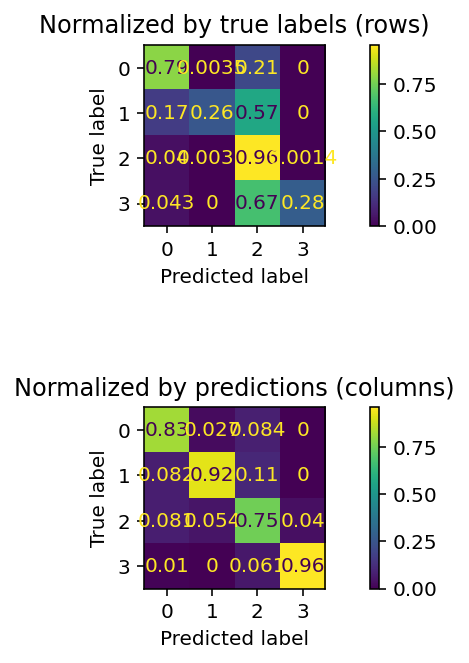

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5))
fig.subplots_adjust(hspace=1, wspace=1)
ax[0].set(title='Normalized by true labels (rows)')
plot_confusion_matrix(clf, X_train, y_train, normalize='true', ax=ax[0])
ax[1].set(title='Normalized by predictions (columns)')
plot_confusion_matrix(clf, X_train, y_train, normalize='pred', ax=ax[1])

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.60      0.66       281
           1       0.45      0.09      0.15       155
           2       0.64      0.92      0.75       530
           3       0.40      0.03      0.06        65

    accuracy                           0.65      1031
   macro avg       0.56      0.41      0.41      1031
weighted avg       0.62      0.65      0.59      1031

